In [18]:
import pandas as pd
import numpy as np
import folium
from datetime import timedelta

import plotly.express as px
import seaborn as sns


# Load Dataframe

## Load
Load the data set into a pandas dataframe.

The data set contains the follwing columns:

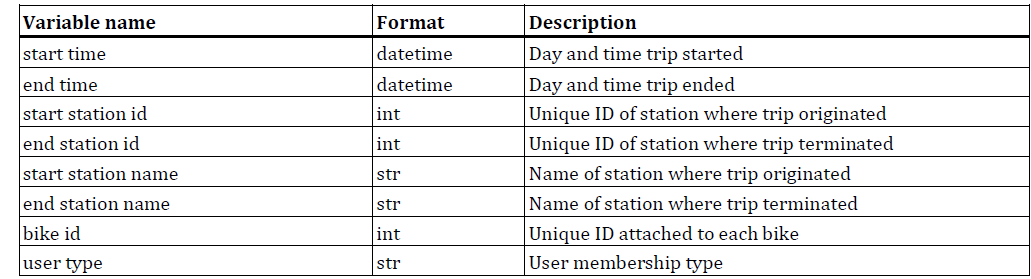


In [19]:
df_boston = pd.read_csv('./data/boston_2015.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})

print(f'Total number of rows: {len(df_boston)}')

df_boston.head() 

Total number of rows: 1122558


,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer


## Prepare the datatypes of the columns

Start time & end time columns need to be transformed to datetime columns. End time column cannot be parsed as an integer as there are '\N' values in the column. These need to be removed first

In [20]:
# Value '\\N' seems to be anomaly -> occurs only once, so drop!
num_occurences = len(df_boston.loc[df_boston["end_station_id"] == "\\N"])
print(f'Number of "\\\\N" occurences in end_station_id column: {num_occurences}')
df_boston.drop(index=df_boston.loc[df_boston["end_station_id"] == "\\N"].index, inplace=True, axis=1)

# now set column to dtype np.int64
df_boston = df_boston.astype({'end_station_id': np.int64})
df_boston.info()

Number of "\\N" occurences in end_station_id column: 1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122557 entries, 0 to 1122557
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   start_time          1122557 non-null  object
 1   end_time            1122557 non-null  object
 2   start_station_id    1122557 non-null  int64 
 3   end_station_id      1122557 non-null  int64 
 4   start_station_name  1122557 non-null  string
 5   end_station_name    1122557 non-null  string
 6   bike_id             1122557 non-null  int64 
 7   user_type           1122557 non-null  string
dtypes: int64(3), object(2), string(3)
memory usage: 77.1+ MB


## Set data type of time columns

As mentioned above the data type of the time columns needs to be set.

In [21]:
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
df_boston.dtypes

start_time            datetime64[ns]
end_time              datetime64[ns]
start_station_id               int64
end_station_id                 int64
start_station_name            string
end_station_name              string
bike_id                        int64
user_type                     string
dtype: object

# Preprocessing

## Check for Duplicates

First check for rows that appear twice in the data set. This check shows that we have no duplicates in the dataset

In [22]:
df_boston.loc[df_boston.duplicated()]

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type


## Check for inconsistent data
### 1. Check if stations ids match to unique station name
Result of the analysis shows that all station_id - station_name pairs are unique

In [23]:
# concatentate end & start tuples
unique_station_tuples = np.concatenate((df_boston[['start_station_id', 'start_station_name']].values.astype('str'), df_boston[['end_station_id', 'end_station_name']].values.astype('str')), axis=0)
# remove duplicates in tuples
unique_station_tuples = np.unique(unique_station_tuples)
# flatten array and the check if there are any duplicate station ids or duplicate station names
_, c = np.unique(unique_station_tuples.flatten(), return_counts=True)
np.unique(c)

array([1])

### 2. Check for bikes being used twice at the same time
It might be the case that there are records that state that a bike is rented twice at the same time. In the following we check if there are such records

In [24]:
df_sorted = df_boston.sort_values(by=['bike_id','start_time'], ascending=True)
tmp = df_sorted[['start_time','end_time', 'bike_id']].copy()

tmp['next_ride']= tmp['start_time'].shift(periods=-1)
tmp['next_bike_id']= tmp['bike_id'].shift(periods=-1)

#compare the id (id_compare) & start time: if id is not similiar we are comparing two different bikes; if id is the same but we need to check if start & end times are consistent
tmp['bike_id_check'] = tmp.apply(lambda x: True if ((x['bike_id'] == x['next_bike_id'])) else False, axis=1)
tmp = tmp.dropna() 
tmp['check'] = tmp.apply(lambda x: True if ((x['next_ride'] >= x['end_time'])) else False, axis=1)

df_duplicates = tmp[(tmp['check']==False)&(tmp['bike_id_check']==True)]
print(f'Wrong entrys: {len(df_duplicates)}')

Wrong entrys: 3


In [25]:
df_duplicates

,start_time,end_time,bike_id,next_ride,next_bike_id,bike_id_check,check
985026,2015-11-01 01:40:30,2015-11-01 02:05:48,582,2015-11-01 01:56:51,582.0,True,False
984998,2015-11-01 01:00:06,2015-11-01 01:18:58,1043,2015-11-01 01:12:35,1043.0,True,False
984962,2015-11-01 01:17:58,2015-11-01 01:44:33,1442,2015-11-01 01:20:14,1442.0,True,False


In total there are three cases where bikes are rented twice at the same time. In that case we just delete the record with the earlier start time

In [26]:
indeces = df_boston.loc[(df_boston['bike_id'].isin(df_duplicates.bike_id)) & (df_boston['start_time'].isin(df_duplicates.start_time))].index
df_boston=df_boston.drop(indeces, axis=0)

### 3. Check for trips where the end time is earlier than the start time
All of these trips occured on the 11th of November between 1 am and 2 am, which was the when the clock change was scheduled in 2015. 

In [27]:
df_boston.loc[df_boston['end_time'] < df_boston['start_time']]

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
984979,2015-11-01 01:44:08,2015-11-01 01:08:25,8,76,Union Square - Brighton Ave. at Cambridge St.,Central Sq Post Office / Cambridge City Hall a...,1447,Subscriber
984980,2015-11-01 01:47:16,2015-11-01 01:03:13,88,74,Inman Square at Vellucci Plaza / Hampshire St,Harvard Square at Mass Ave/ Dunster,865,Subscriber
984981,2015-11-01 01:48:11,2015-11-01 01:13:02,57,132,Columbus Ave. at Mass. Ave.,Summer St at Cutter St,383,Subscriber
984985,2015-11-01 01:50:17,2015-11-01 01:32:53,121,13,West Broadway at Dorchester St,Boston Medical Center - East Concord at Harri...,196,Subscriber
984986,2015-11-01 01:50:36,2015-11-01 01:28:45,121,13,West Broadway at Dorchester St,Boston Medical Center - East Concord at Harri...,1371,Subscriber
984987,2015-11-01 01:51:24,2015-11-01 01:03:22,161,20,West Broadway at D Street,Aquarium Station - 200 Atlantic Ave.,1019,Customer
984988,2015-11-01 01:52:19,2015-11-01 01:03:00,88,74,Inman Square at Vellucci Plaza / Hampshire St,Harvard Square at Mass Ave/ Dunster,846,Subscriber
984989,2015-11-01 01:53:11,2015-11-01 01:13:00,45,113,Yawkey Way at Boylston St.,Andrew Station - Dorchester Ave at Humboldt Pl,1503,Subscriber
984990,2015-11-01 01:55:10,2015-11-01 01:06:18,33,67,Kenmore Sq / Comm Ave,MIT at Mass Ave / Amherst St,1376,Customer
984991,2015-11-01 01:55:13,2015-11-01 01:07:03,45,4,Yawkey Way at Boylston St.,Tremont St. at Berkeley St.,369,Customer


In order to overcome this problem, we just add 1 hour to the end time of these trips. Thereby the trip length can be correctly reconstructed.

In [28]:
df_boston.loc[df_boston['end_time'] < df_boston['start_time'], 'end_time'] = df_boston.loc[df_boston['end_time'] < df_boston['start_time'], 'end_time'] + timedelta(hours=1)

# Calculate trip length feature
A very basic feature which might be important for further analysis is the trip lenght feature. It is calculated by subtracting start time from end time

In [29]:
df_boston['trip_length'] = (df_boston['end_time'] - df_boston['start_time'])
df_boston['trip_length'] = df_boston['trip_length'] / np.timedelta64(1, 's')
df_boston.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0


# Insert geo data into data set
In order to be able to conduct an analysis of the demand from a geographical perspective, we need to insert location data of the bike stations. 
On the blue bike website, we found the several datasets which contain longitude & latitude data for the bike station ids we can find in our data set (source: https://s3.amazonaws.com/hubway-data/index.html)
Under the link we can find trip data from several years which also includes longitude & latitude of the respective bike stations. Basically our original datasets is a preprocessed version of these data sets. 

First, we extracted all the id-longitude-latitude pairs. And then checked if the number of stations we got from the external data sets matches the number of stations that are in our source data set. This is the case here.

In [30]:
#boston blue bikes stations data
df_january = pd.read_csv('./data/201501-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_sep = pd.read_csv('./data/201509-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_july = pd.read_csv('./data/201507-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_oct = pd.read_csv('./data/201510-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_dec = pd.read_csv('./data/201512-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])

unique_stations_external=np.unique(np.concatenate((df_january[['start station id', 'start station latitude', 'start station longitude']].values, df_january[['end station id', 'end station latitude', 'end station longitude']].values,df_july[['start station id', 'start station latitude', 'start station longitude']].values, df_july[['end station id', 'end station latitude', 'end station longitude']].values, df_sep[['start station id', 'start station latitude', 'start station longitude']].values, df_sep[['end station id', 'end station latitude', 'end station longitude']].values, df_oct[['start station id', 'start station latitude', 'start station longitude']].values, df_oct[['end station id', 'end station latitude', 'end station longitude']].values, df_dec[['start station id', 'start station latitude', 'start station longitude']].values, df_dec[['end station id', 'end station latitude', 'end station longitude']].values)), axis=0)
unique_stations_original=np.unique(np.concatenate((df_boston['start_station_name'].values, df_boston['end_station_name'].values)))
print(f'# stations from original data: {len(unique_stations_original)} | # stations from external data: {len(unique_stations_external)}')
df_unique_stations = pd.DataFrame(unique_stations_external, columns=['station_id', 'station_latitude', 'station_longitude'])

# stations from original data: 156 | # stations from external data: 156


Now we have to merge the id-longitude-latitude pairs with our source data set.

In [31]:
df_unique_stations.columns = ['start_station_id', 'start_station_latitude', 'start_station_longitude']
df_boston = df_boston.merge(df_unique_stations, how='left', on='start_station_id')
df_unique_stations.columns = ['end_station_id', 'end_station_latitude', 'end_station_longitude']
df_boston = df_boston.merge(df_unique_stations, how='left', on='end_station_id')
df_boston.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0,42.387995,-71.119084,42.373379,-71.111075
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0,42.361962,-71.092053,42.372969,-71.094445
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0,42.366277,-71.091690,42.365070,-71.103100
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0,42.356954,-71.113687,42.374035,-71.101427


# Save to csv
Save the processed dataframe to csv file for further processing

In [32]:
df_boston.to_csv('./data/prepared/rides_data_prepared.csv')

## Weather Data added to df

In [34]:
df_weather = pd.read_csv('./data/weather_hourly_boston.csv')

In [37]:
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'], format='%Y-%m-%d %X')
df_boston['date_time'] = df_boston['start_time'].dt.round('1h')

In [38]:
df_joined = df_boston.merge(df_weather, how = 'left', on = 'date_time')

df_joined.head(10)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,date_time,max_temp,min_temp,precip
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 00:00:00,NaN,NaN,NaN
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0,42.361962,-71.092053,42.372969,-71.094445,2015-01-01 00:00:00,NaN,NaN,NaN
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0,42.366277,-71.091690,42.365070,-71.103100,2015-01-01 01:00:00,NaN,NaN,NaN
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 01:00:00,NaN,NaN,NaN
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0,42.356954,-71.113687,42.374035,-71.101427,2015-01-01 01:00:00,NaN,NaN,NaN
5,2015-01-01 01:28:27,2015-01-01 01:33:38,88,76,Inman Square at Vellucci Plaza / Hampshire St,Central Sq Post Office / Cambridge City Hall a...,685,Subscriber,311.0,42.374035,-71.101427,42.366426,-71.105495,2015-01-01 01:00:00,NaN,NaN,NaN
6,2015-01-01 01:34:54,2015-01-01 01:55:54,91,118,One Kendall Square at Hampshire St / Portland St,Linear Park - Mass. Ave. at Cameron Ave.,940,Subscriber,1260.0,42.366277,-71.091690,42.397828,-71.130516,2015-01-01 02:00:00,NaN,NaN,NaN
7,2015-01-01 02:32:35,2015-01-01 02:38:13,68,95,Central Square at Mass Ave / Essex St,Cambridge St - at Columbia St / Webster Ave,656,Subscriber,338.0,42.365070,-71.103100,42.372969,-71.094445,2015-01-01 03:00:00,NaN,NaN,NaN
8,2015-01-01 04:41:58,2015-01-01 04:49:08,117,76,Binney St / Sixth St,Central Sq Post Office / Cambridge City Hall a...,134,Customer,430.0,42.366095,-71.086388,42.366426,-71.105495,2015-01-01 05:00:00,NaN,NaN,NaN
9,2015-01-01 08:00:15,2015-01-01 08:05:04,67,75,MIT at Mass Ave / Amherst St,Lafayette Square at Mass Ave / Main St / Colum...,23,Subscriber,289.0,42.358100,-71.093198,42.363465,-71.100573,2015-01-01 08:00:00,-5.6,-5.6,0.0
